In [53]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import process_time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [54]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'weatherAUS.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [55]:
weather_df["id"] = weather_df.index + 1

In [56]:
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,5


In [57]:
print(weather_df.shape)

(142193, 25)


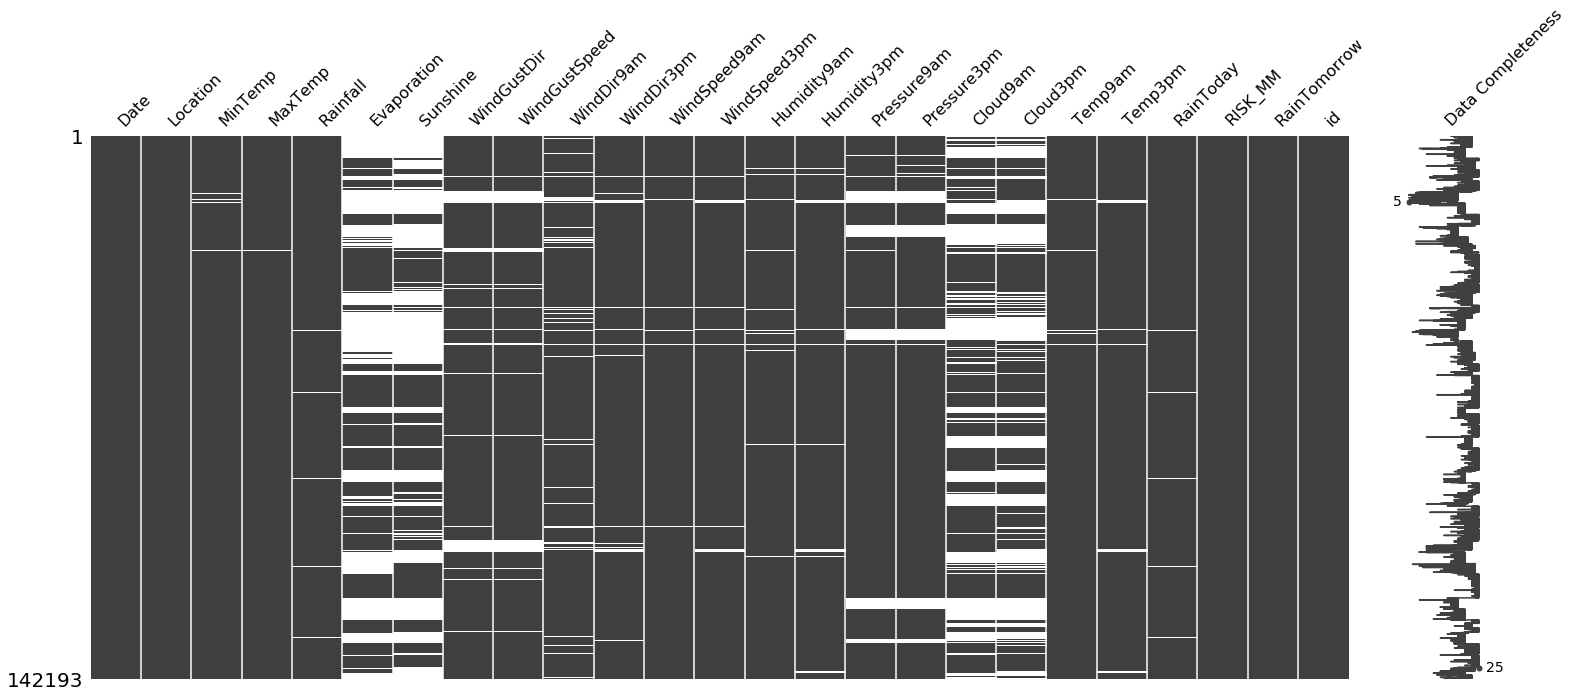

In [58]:
missingno.matrix(weather_df, labels=True)

There are 49 locations


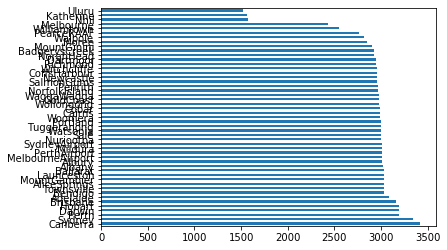

In [59]:
weather_df.Location.value_counts().plot(kind='barh')
print('There are {} locations'.format(len(weather_df.Location.value_counts())))

In [60]:
print(weather_df.MinTemp.describe())
print('There are {} missing values'.format(weather_df.MinTemp.isnull().sum()))

count    141556.000000
mean         12.186400
std           6.403283
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64
There are 637 missing values


In [39]:
#weather_df['MinTemp'].fillna(weather_df['MinTemp'].mean(), inplace=True)
#print('There are {} missing values'.format(weather_df.MinTemp.isna().sum()))

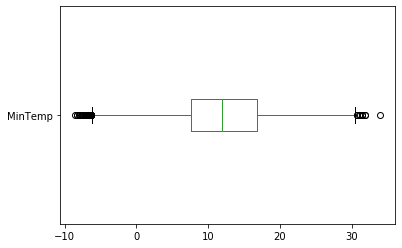

In [61]:
weather_df.MinTemp.plot(kind='box', vert=False)

In [62]:
print(weather_df.MaxTemp.describe())
print('There are {} missing values'.format(weather_df.MaxTemp.isnull().sum()))

count    141871.000000
mean         23.226784
std           7.117618
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64
There are 322 missing values


In [63]:
#weather_df['MaxTemp'].fillna(weather_df['MaxTemp'].mean(), inplace=True)
#print('There are {} missing values'.format(weather_df.MaxTemp.isna().sum()))

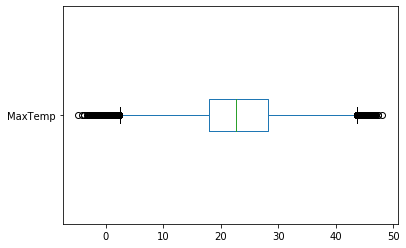

In [64]:
weather_df.MaxTemp.plot(kind='box', vert=False)

There could be an issue with filling the temp with just the mean. Possibilities of a min temp of 25 and the max temp will be 23. That will make no sense. Best to use a prediction model perhaps?

In [65]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [66]:
weather_df.loc[weather_df.MaxTemp.isna() & weather_df.MinTemp.isna(), ['MinTemp']] = 1000
weather_df.loc[weather_df.MinTemp == 1000, ['MaxTemp']] = weather_df.MaxTemp.mean()
weather_df.loc[weather_df['MinTemp'] == 1000, ['MinTemp']] = np.nan

In [67]:
weather_df.loc[weather_df.MinTemp.isnull() & weather_df.MaxTemp.isnull()] 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


Convert nan matches to 1000
Then fill na
Then drop the 1000
then fill with the means

In [68]:
print('Missing Max Temp: {}, Missing Min Temp: {}'.format(weather_df.MaxTemp.isnull().sum(), weather_df.MinTemp.isnull().sum()))

Missing Max Temp: 234, Missing Min Temp: 637


In [69]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MaxTemp'], Temp_df['MaxTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [70]:
Temp_null = weather_df[weather_df.MaxTemp.isnull()]
Max_null = pd.concat([Temp_null.MinTemp, Temp_null.MaxTemp], axis=1)
Max_null = Max_null.drop(columns=['MaxTemp'])
Max_null = Max_null.dropna()
Temp_min_null = weather_df[weather_df.MinTemp.isnull()]
Min_null = pd.concat([Temp_min_null.MinTemp, Temp_min_null.MaxTemp], axis=1)
Min_null = Min_null.drop(columns=['MinTemp'])
Min_null = Min_null.dropna()

In [71]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
score = []
for k in Neighbors:
    start_time = process_time()
    max_model = KNeighborsRegressor(n_neighbors=k)
    max_model.fit(X_train, y_train)
    max_predictions = max_model.predict(X_test)
    mse = mean_squared_error(max_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 6.781542024023599 and took 0.2662264740000069 seconds to compute
KNN on neighbors = 3 has a rmse of 5.689193466811331 and took 0.2612338649999799 seconds to compute
KNN on neighbors = 5 has a rmse of 5.389036449222861 and took 0.2649728500000208 seconds to compute
KNN on neighbors = 7 has a rmse of 5.197258706930612 and took 0.2741033199999947 seconds to compute
KNN on neighbors = 9 has a rmse of 5.111150780373005 and took 0.27610267699998303 seconds to compute
KNN on neighbors = 11 has a rmse of 5.050606118728501 and took 0.28245992899999806 seconds to compute
KNN on neighbors = 13 has a rmse of 5.004965838249654 and took 0.2999830130000021 seconds to compute
KNN on neighbors = 15 has a rmse of 4.975065551999592 and took 0.30209586399999466 seconds to compute
KNN on neighbors = 17 has a rmse of 4.951732633023714 and took 0.2920973500000059 seconds to compute
KNN on neighbors = 19 has a rmse of 4.936544310224405 and took 0.3139389399999857 seconds to 

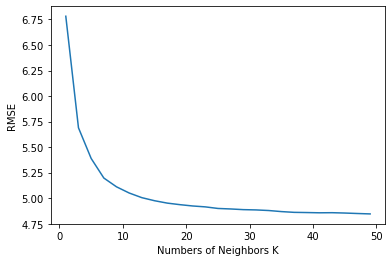

In [72]:
plt.plot(Neighbors, score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [73]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_max_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_max_model.fit(X_train, y_train)
        predictions = cv_max_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores)) 

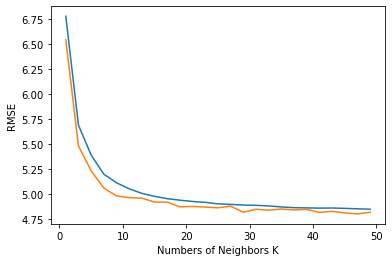

In [74]:
plt.plot(Neighbors, score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [75]:
optimal_k = Neighbors[cv_scores.index(min(cv_scores))]
print(optimal_k)

47


In [76]:
max_model = KNeighborsRegressor(n_neighbors=47)
max_model.fit(X_train, y_train)
max_predictions = max_model.predict(Max_null)
max_results = pd.DataFrame(max_predictions, columns=['MaxTemp'])
max_results = max_results.round(1)
weather_df['MaxTemp'] = weather_df['MaxTemp'].fillna(max_results['MaxTemp'].values[0])

In [77]:
weather_df.MaxTemp.describe()

count    142193.000000
mean         23.231513
std           7.110508
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64

In [80]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
139360,2013-11-03,Katherine,26.9,26.1,0.0,9.2,NaN,NE,33.0,N,...,1011.9,1006.7,5.0,4.0,31.0,41.0,No,0.0,No,139361
140444,2016-10-31,Katherine,28.0,26.1,0.0,14.6,NaN,NW,41.0,NNW,...,1010.7,1005.5,5.0,NaN,33.0,NaN,No,0.0,No,140445


In [81]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, 'MaxTemp'] = weather_df['MinTemp']

In [82]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp', 'MaxTemp']]

,MinTemp,MaxTemp


In [86]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MinTemp'], Temp_df['MinTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [87]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    min_model = KNeighborsRegressor(n_neighbors=k)
    min_model.fit(X_train, y_train)
    min_predictions = min_model.predict(X_test)
    mse = mean_squared_error(min_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 6.143737579349456 and took 0.24924220900001615 seconds to compute
KNN on neighbors = 3 has a rmse of 5.010541080800418 and took 0.25114160800001173 seconds to compute
KNN on neighbors = 5 has a rmse of 4.675014116930663 and took 0.2512353789999793 seconds to compute
KNN on neighbors = 7 has a rmse of 4.5965284810282645 and took 0.2626430859999971 seconds to compute
KNN on neighbors = 9 has a rmse of 4.532588585636658 and took 0.2715432319999991 seconds to compute
KNN on neighbors = 11 has a rmse of 4.497475832170381 and took 0.2749901829999999 seconds to compute
KNN on neighbors = 13 has a rmse of 4.47048341274752 and took 0.28243172200001254 seconds to compute
KNN on neighbors = 15 has a rmse of 4.443802341669668 and took 0.28741264699999647 seconds to compute
KNN on neighbors = 17 has a rmse of 4.419636528778564 and took 0.2833313859999862 seconds to compute
KNN on neighbors = 19 has a rmse of 4.410728677841584 and took 0.3019319730000234 seconds to

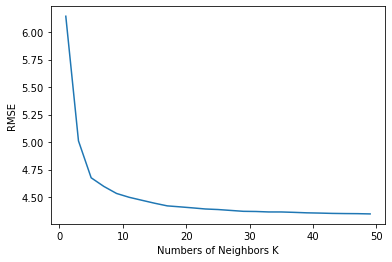

In [88]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [89]:
min_cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    min_cv_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        min_cv_model.fit(X_train, y_train)
        predictions = min_cv_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    min_cv_scores.append(np.min(temp_cv_scores)) 

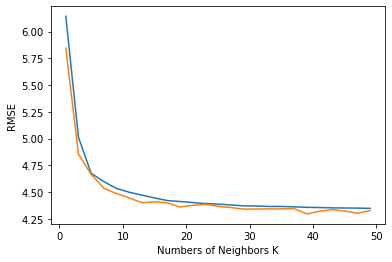

In [90]:
plt.plot(Neighbors, min_score, Neighbors, min_cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [91]:
optimal_k = Neighbors[min_cv_scores.index(min(min_cv_scores))]
print(optimal_k)

39


In [92]:
min_model = KNeighborsRegressor(n_neighbors=37)
min_model.fit(X_train, y_train)
min_predictions = min_model.predict(Min_null)
min_results = pd.DataFrame(min_predictions, columns=['MinTemp'])
min_results = min_results.round(1)
weather_df['MinTemp'] = weather_df['MinTemp'].fillna(min_results['MinTemp'].values[0])

In [93]:
weather_df.MinTemp.describe()

count    142193.000000
mean         12.173021
std           6.392036
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64

In [94]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
50953,2009-06-06,MountGinini,9.2,3.2,NaN,NaN,NaN,WSW,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4,Yes,50954
50973,2009-06-27,MountGinini,9.2,4.2,NaN,NaN,NaN,NNE,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,Yes,50974
50981,2009-07-07,MountGinini,9.2,-1.3,NaN,NaN,NaN,E,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.6,NaN,0.0,No,50982
51032,2009-08-30,MountGinini,9.2,0.1,32.6,NaN,NaN,W,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.4,Yes,2.4,Yes,51033
51034,2009-09-01,MountGinini,9.2,6.6,2.6,NaN,NaN,W,61.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0.0,No,51035
51038,2009-09-05,MountGinini,9.2,7.6,0.2,NaN,NaN,WSW,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.9,No,0.0,No,51039
51053,2009-09-24,MountGinini,9.2,4.9,NaN,NaN,NaN,SW,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No,51054
51064,2009-10-05,MountGinini,9.2,8.6,6.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,3.8,Yes,51065
51065,2009-10-06,MountGinini,9.2,5.6,3.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,Yes,5.4,Yes,51066
51070,2009-10-11,MountGinini,9.2,7.9,0.0,NaN,NaN,W,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.2,No,2.4,Yes,51071


In [96]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp']] = weather_df['MaxTemp']

In [99]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [101]:
print('There is {} missing values in MinTemp'.format(weather_df.MinTemp.isnull().sum()))
print('There is {} missing values in MaxTemp'.format(weather_df.MaxTemp.isnull().sum()))

There is 0 missing values in MinTemp
There is 0 missing values in MaxTemp


In [102]:
print(weather_df.Rainfall.describe())
print('There are {} missing values'.format(weather_df.Rainfall.isnull().sum()))

count    140787.000000
mean          2.349974
std           8.465173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64
There are 1406 missing values


In [61]:
weather_df[weather_df.Rainfall.isnull()].Location.value_counts()

Williamtown      177
Melbourne        137
PearceRAAF       116
MountGinini       91
Adelaide          70
Moree             63
GoldCoast         56
Penrith           53
BadgerysCreek     51
Walpole           49
Richmond          45
NorahHead         41
Wollongong        40
Tuggeranong       39
Brisbane          29
Witchcliffe       28
Newcastle         26
Cairns            24
Albany            20
NorfolkIsland     20
Albury            20
Uluru             19
WaggaWagga        18
Canberra          16
Katherine         14
SalmonGums        14
CoffsHarbour      13
Portland          12
Ballarat          11
Watsonia           9
Sale               8
Cobar              8
Launceston         8
MountGambier       8
Nuriootpa          6
Woomera            6
Townsville         6
Sydney             6
AliceSprings       6
Hobart             5
SydneyAirport      4
Dartmoor           4
Nhil               4
Bendigo            4
Mildura            2
Name: Location, dtype: int64

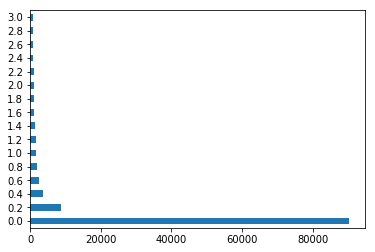

In [11]:
weather_df.Rainfall.value_counts()[:3].plot(kind='barh')

In [12]:
print(weather_df.Evaporation.isnull().sum())
print(len(weather_df.Evaporation))

60843
142193


In [13]:
weather_df.Sunshine.describe()
print(weather_df.Sunshine.isnull().sum())

67816


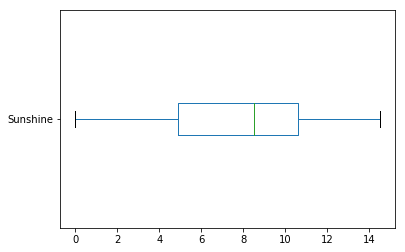

In [14]:
weather_df.Sunshine.plot(kind='box', vert=False)

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64
9330


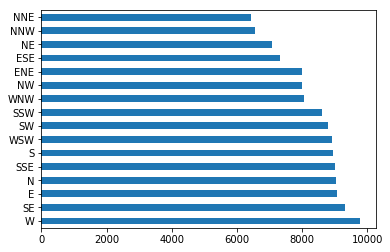

In [15]:
print(weather_df.WindGustDir.value_counts())
print(weather_df.WindGustDir.isnull().sum())
weather_df.WindGustDir.value_counts().plot(kind='barh')

count    132923.000000
mean         39.984292
std          13.588801
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
9270


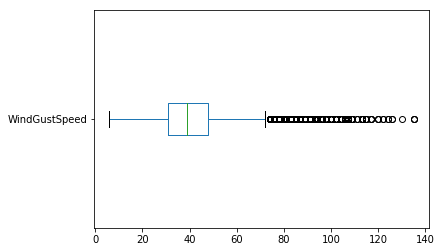

In [16]:
print(weather_df.WindGustSpeed.describe())
print(weather_df.WindGustSpeed.isnull().sum())
weather_df.WindGustSpeed.plot(kind='box', vert=False)

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64
3778


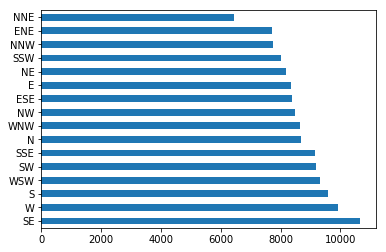

In [17]:
print(weather_df.WindDir3pm.value_counts())
print(weather_df.WindDir3pm.isnull().sum())
weather_df.WindDir3pm.value_counts().plot(kind='barh')